In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from nltk.tokenize import word_tokenize
from datasets import load_dataset

In [74]:
from datasets import load_dataset

sick = load_dataset("sick")
print(sick)

print("DONE!!!")

DatasetDict({
    train: Dataset({
        features: ['id', 'sentence_A', 'sentence_B', 'label', 'relatedness_score', 'entailment_AB', 'entailment_BA', 'sentence_A_original', 'sentence_B_original', 'sentence_A_dataset', 'sentence_B_dataset'],
        num_rows: 4439
    })
    validation: Dataset({
        features: ['id', 'sentence_A', 'sentence_B', 'label', 'relatedness_score', 'entailment_AB', 'entailment_BA', 'sentence_A_original', 'sentence_B_original', 'sentence_A_dataset', 'sentence_B_dataset'],
        num_rows: 495
    })
    test: Dataset({
        features: ['id', 'sentence_A', 'sentence_B', 'label', 'relatedness_score', 'entailment_AB', 'entailment_BA', 'sentence_A_original', 'sentence_B_original', 'sentence_A_dataset', 'sentence_B_dataset'],
        num_rows: 4906
    })
})
DONE!!!


In [75]:
dataset_used = sick

premise_train = dataset_used["train"]["sentence_A"]
hypothesis_train = dataset_used["train"]["sentence_B"]
labels_train = dataset_used["train"]["label"]

premise_val = dataset_used["validation"]["sentence_A"]
hypothesis_val = dataset_used["validation"]["sentence_B"]
labels_val = dataset_used["validation"]["label"]

premise_test = dataset_used["test"]["sentence_A"]
hypothesis_test = dataset_used["test"]["sentence_B"]
labels_test = dataset_used["test"]["label"]

print(len(premise_train), len(premise_val), len(premise_test))

labels_train = torch.tensor(labels_train)
labels_val = torch.tensor(labels_val)
labels_test = torch.tensor(labels_test)

print("DONE!!!!")

4439 495 4906
DONE!!!!


In [76]:
# Vocab...
from collections import Counter
from nltk.tokenize import word_tokenize
import time

start_time = time.time()
def build_vocab(texts_A, texts_B):
    vocab = Counter()
    for text in texts_A + texts_B:
        tokens = word_tokenize(text.lower())
        vocab.update(tokens)
        
    vocab_dict = {}
    vocab_dict["<UNK>"] = 0
    idx = 1 
#     for word in vocab:
    for word in sorted(vocab):
        vocab_dict[word] = idx
        idx += 1
    return vocab_dict

vocab = build_vocab(premise_train, hypothesis_train)
print("DONE!!!")
print("Time Taken :", time.time() - start_time)

DONE!!!
Time Taken : 1.2805395126342773


In [77]:
# HyperParameters...
vocab_size = len(vocab) + 1 
embedding_dim = 100
hidden_dim = 30
output_dim = 3
max_len = 50
print(vocab_size)
print("DONE!!!")

2171
DONE!!!


In [78]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from nltk.tokenize import word_tokenize

class NLIDataset(Dataset):
    def __init__(self, premise, hypothesis, label, vocab, max_len):
        self.premise = premise
        self.hypothesis = hypothesis
        self.label = label
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.premise)

    def __getitem__(self, idx):
        premise = self.premise[idx]
        hypothesis = self.hypothesis[idx]
        label = self.label[idx]
        
        if label == -1:
            return None

        # Clipping
        premise = [self.vocab.get(token, 0) for token in word_tokenize(premise.lower())][:self.max_len]
        hypothesis = [self.vocab.get(token, 0) for token in word_tokenize(hypothesis.lower())][:self.max_len]

        # Padding
        padded_tokens_premise = torch.tensor(premise + [0] * (self.max_len - len(premise)), dtype=torch.long)
        padded_tokens_hypothesis = torch.tensor(hypothesis + [0] * (self.max_len - len(hypothesis)), dtype=torch.long)

        return padded_tokens_premise, padded_tokens_hypothesis, label
print("DONE!!!")

DONE!!!


In [79]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from nltk.tokenize import word_tokenize
from collections import Counter

# Define the LSTM model
class LSTMModel1(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)


    def forward(self, premise, hypothesis):
        premise_embedded = self.embedding(premise)
        hypothesis_embedded = self.embedding(hypothesis)

        _, (premise_hidden, _) = self.lstm(premise_embedded)
        _, (hypothesis_hidden, _) = self.lstm(hypothesis_embedded)

        # We only take the hidden state of the last time step
        premise_hidden = premise_hidden.squeeze(0)
        hypothesis_hidden = hypothesis_hidden.squeeze(0)

        # Concatenate the hidden states of premise and hypothesis
        combined_hidden = torch.cat((premise_hidden, hypothesis_hidden), dim=1)
#         print("Shape of combined_hidden tensor:", combined_hidden.shape)


        # Apply fully connected layer
        output = self.fc(combined_hidden)

        return output

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Multiply by 2 because of bidirectional LSTM

    def forward(self, premise, hypothesis):
        premise_embedded = self.embedding(premise)
        hypothesis_embedded = self.embedding(hypothesis)

        _, (premise_hidden, _) = self.lstm(premise_embedded)
        _, (hypothesis_hidden, _) = self.lstm(hypothesis_embedded)

        # Concatenate the hidden states of both directions
        combined_hidden = torch.cat((premise_hidden[-2,:,:], premise_hidden[-1,:,:], hypothesis_hidden[-2,:,:], hypothesis_hidden[-1,:,:]), dim=1)

        # Apply fully connected layer
        output = self.fc(combined_hidden)

        return output


# Parameters for the model
vocab_size = len(vocab)  # Size of the vocabulary
embedding_dim = 100  # Dimension of word embeddings
hidden_dim = 128  # Dimension of hidden state of LSTM
output_dim = 3  # Number of output classes (contradiction, neutral, entailment)

# Instantiate the model
model = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Function to calculate accuracy
def calculate_accuracy(predictions, labels):
    _, predicted = torch.max(predictions, 1)
    correct = (predicted == labels).float()
    accuracy = correct.sum() / len(correct)
    return accuracy

# Function to train the model
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for premise, hypothesis, labels in iterator:
        optimizer.zero_grad()

        predictions = model(premise, hypothesis)
        loss = criterion(predictions, labels)
        acc = calculate_accuracy(predictions, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# Function to evaluate the model
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():
        for premise, hypothesis, labels in iterator:
            predictions = model(premise, hypothesis)
            loss = criterion(predictions, labels)
            acc = calculate_accuracy(predictions, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [80]:
max_len= 30
train_dataset = NLIDataset(premise_train, hypothesis_train, labels_train, vocab, max_len)
val_dataset = NLIDataset(premise_val, hypothesis_val, labels_val, vocab, max_len)
test_dataset = NLIDataset(premise_test, hypothesis_test, labels_test, vocab, max_len)
print(len(train_dataset))

train_dataset_filtered = [data for data in train_dataset if data is not None]
val_dataset_filtered = [data for data in val_dataset if data is not None]
test_dataset_filtered = [data for data in test_dataset if data is not None]
print(len(train_dataset_filtered))


train_loader = DataLoader(train_dataset_filtered, batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset_filtered, batch_size=64, drop_last=True)
test_loader = DataLoader(test_dataset_filtered, batch_size=64, drop_last=True)

print("DONE!!!")

4439
4439
DONE!!!


In [82]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming train_loader and test_loader are already defined

class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(BiLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2 * 2, output_dim)  # Double the hidden_dim for bidirectional LSTM and 2 for premise and hypothesis

    def forward(self, premise, hypothesis):
        premise_embedded = self.embedding(premise)
        hypothesis_embedded = self.embedding(hypothesis)

        _, (premise_hidden, _) = self.lstm(premise_embedded)
        _, (hypothesis_hidden, _) = self.lstm(hypothesis_embedded)

        # Concatenate the hidden states of both directions for both premise and hypothesis
        combined_hidden = torch.cat((premise_hidden[-2,:,:], premise_hidden[-1,:,:], hypothesis_hidden[-2,:,:], hypothesis_hidden[-1,:,:]), dim=1)

        # Apply fully connected layer
        output = self.fc(combined_hidden)

        return output

model = BiLSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5

# Training loop
for epoch in range(num_epochs):
    print(epoch + 1, "Epoch........")
    model.train()  # Set the model to training mode
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    
    for premise, hypothesis, labels in train_loader:
        premise, hypothesis, labels = premise.to(device), hypothesis.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad() 
        
        # Forward pass
        outputs = model(premise, hypothesis)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Compute accuracy
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        
        total_loss += loss.item()
    
    # Print epoch statistics
    avg_loss = total_loss / len(train_loader)
    accuracy = total_correct / total_samples
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

# Evaluation on test set
model.eval()  # Set the model to evaluation mode
total_correct = 0
total_samples = 0

true_labels = []
predicted_labels = []

for premise, hypothesis, labels in test_loader:
    premise, hypothesis, labels = premise.to(device), hypothesis.to(device), labels.to(device)  # Move data to GPU
    outputs = model(premise, hypothesis)
    _, predicted = torch.max(outputs, 1)
    total_correct += (predicted == labels).sum().item()
    total_samples += labels.size(0)
    
    true_labels.extend(labels.cpu().numpy())
    predicted_labels.extend(predicted.cpu().numpy())

accuracy = total_correct / total_samples
print(f'Accuracy on test set: {accuracy:.4f}')

1 Epoch........
Epoch [1/5], Loss: 0.8822, Accuracy: 0.5770
2 Epoch........
Epoch [2/5], Loss: 0.7641, Accuracy: 0.6119
3 Epoch........
Epoch [3/5], Loss: 0.7142, Accuracy: 0.6255
4 Epoch........
Epoch [4/5], Loss: 0.6795, Accuracy: 0.6499
5 Epoch........
Epoch [5/5], Loss: 0.6416, Accuracy: 0.6793
Accuracy on test set: 0.5876


In [83]:
predicted_labels = []
true_labels = []

for premise, hypothesis, labels in test_loader:
    premise = premise.to(device)
    hypothesis = hypothesis.to(device)
    labels = labels.to(device)
    outputs = model(premise, hypothesis)
    _, predicted = torch.max(outputs, 1)
    predicted_labels.extend(predicted.tolist())
    true_labels.extend(labels.tolist())

In [84]:
test_labels, test_preds = true_labels, predicted_labels

Test Accuracy : 58.76%
F1 Score : 58.83%
Recall Score : 58.76%
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.49      0.48      1404
           1       0.65      0.61      0.63      2748
           2       0.61      0.69      0.65       712

    accuracy                           0.59      4864
   macro avg       0.57      0.60      0.58      4864
weighted avg       0.59      0.59      0.59      4864



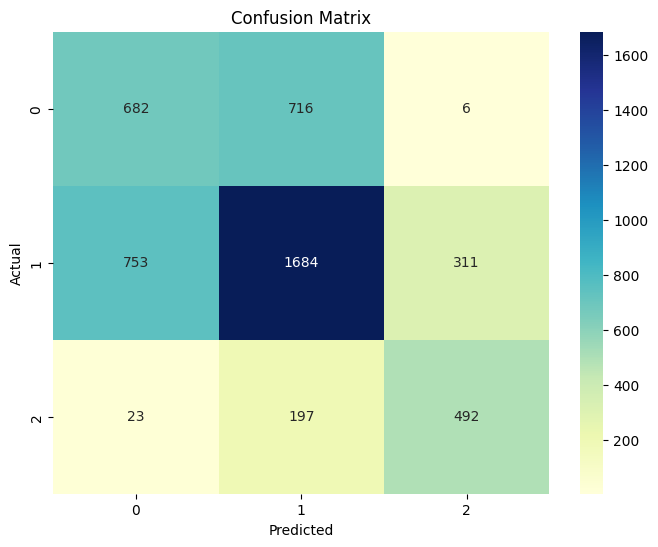

In [85]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Accuracy
test_accuracy = accuracy_score(test_labels, test_preds)
print("Test Accuracy : {:.2f}%".format(test_accuracy * 100))

# F1 Score
f1 = f1_score(test_labels, test_preds, average='weighted')
print("F1 Score : {:.2f}%".format(f1 * 100))

# Recall
recall = recall_score(test_labels, test_preds, average='weighted')
print("Recall Score : {:.2f}%".format(recall * 100))

# classification_report
class_report = classification_report(test_labels, test_preds)
print("Classification Report:")
print(class_report)

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', xticklabels=np.unique(test_labels), yticklabels=np.unique(test_labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()